## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 11: Classifers, Notebook 1: kNN

Figures demonstrating k nearest neighbors (kNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import KNeighborsClassifier
import math

import seaborn as sns; sns.set()

/Users/Andrew/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
# create a custom color map with nice colors

from matplotlib.colors import LinearSegmentedColormap
dot_clr_0 = np.array((79, 135, 219))/255.  # blue
dot_clr_1 = np.array((255, 141, 54))/255.  # orange
dot_cmap = LinearSegmentedColormap.from_list('dot_map', [dot_clr_0, dot_clr_1], N=100)

In [4]:
# Show a scatter plot with blue/orange colors and no ticks

def show_Xy(X, y, filename):
    plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap=dot_cmap)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [5]:
# Create the "smile" dataset. A curve for the smile with a circle at each end.
# All the magic values were picked by hand.

def make_smile(num_samples = 20, thickness=0.3, noise=0.0):
    np.random.seed(42)
    X = []
    y = []
    for i in range(num_samples):
        px = np.random.uniform(-1.5, 1.5)
        py = np.random.uniform(-1, 1)
        c = 0
        if (px - -0.8)**2 + (py-.4)**2 < thickness**2:
            c = 1
        if (px - 0.8)**2 + (py-.4)**2 < thickness**2:
            c = 1
        theta = np.arctan2(py-.4, px)
        r = math.sqrt((px**2)+((py-.4)**2))
        if (theta < 0) and (r > .8-thickness) and (r < .8+thickness):
            c = 1
        px += np.random.uniform(-noise, noise)
        py += np.random.uniform(-noise, noise)
        X.append([px,py])
        y.append(c)
    return (np.array(X),y)

In [6]:
# Create the "happy face" dataset by adding some eyes to the smile.
# All the magic values were picked by hand.

def make_happy_face(num_samples = 20, thickness=0.3, noise=0.0):
    np.random.seed(42)
    X = []
    y = []
    eye_x = .5
    eye_y = 1.5
    for i in range(num_samples):
        px = np.random.uniform(-1.5, 1.5)
        py = np.random.uniform(-1, 2.0)
        c = 0
        if (px - eye_x)**2 + (py-eye_y)**2 < thickness**2:
            c = 1
        if (px - -eye_x)**2 + (py-eye_y)**2 < thickness**2:
            c = 1
        if (px - -0.8)**2 + (py-.4)**2 < thickness**2:
            c = 1
        if (px - 0.8)**2 + (py-.4)**2 < thickness**2:
            c = 1
        theta = np.arctan2(py-.4, px)
        r = math.sqrt((px**2)+((py-.4)**2))
        if (theta < 0) and (r > .8-thickness) and (r < .8+thickness):
            c = 1
        px += np.random.uniform(-noise, noise)
        py += np.random.uniform(-noise, noise)
        X.append([px,py])
        y.append(c)
    return (np.array(X),y)

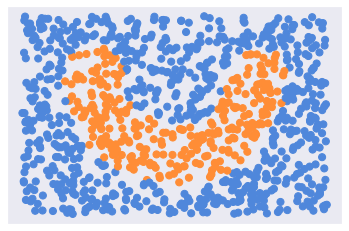

In [7]:
# Show the clean smile

X_clean, y_clean = make_smile(1000, .3, 0)
show_Xy(X_clean, y_clean, 'KNN-smile-data-clean')

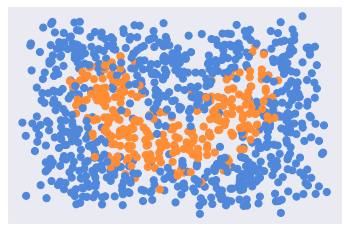

In [8]:
# Show the noisy smile

X_noisy, y_noisy = make_smile(1000, .3, .25)
show_Xy(X_noisy, y_noisy, 'KNN-smile-data-noisy')

In [9]:
# Show a grid of k-nearest-neighbors (kNN) results for different values of k. 
# For large values of k, this can take a little while.

def show_fit_grid(X, y, data_version):
    k_list = [1, 2, 3, 4, 5, 6, 10, 20, 50]
    plt.figure(figsize=(8,6))
    resolution = 500
    xmin = np.min(X[:,0]) - .1
    xmax = np.max(X[:,0]) + .1
    ymin = np.min(X[:,1]) - .1
    ymax = np.max(X[:,1]) + .1
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution))
    zin = np.array([xx.ravel(), yy.ravel()]).T
    for i in range(9):
        plt.subplot(3, 3, i+1)
        num_neighbors = k_list[i]
        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(X,y)
        Z = knn.predict(zin)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=dot_cmap)
        #plt.scatter(X[:,0], X[:,1], c=y, s=5, alpha=0.3, cmap='cool')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title('k='+str(num_neighbors))
    plt.tight_layout()
    file_helper.save_figure('KNN-smile-grid-'+data_version)
    plt.show()

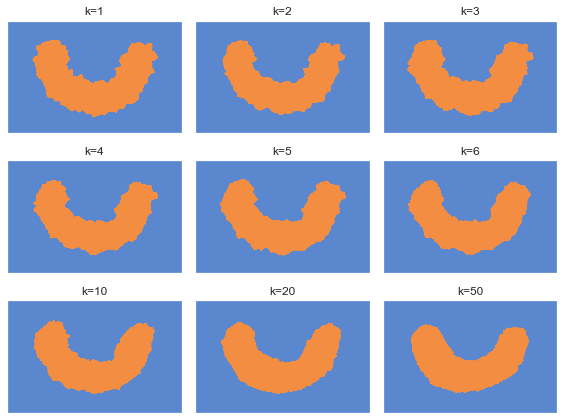

In [10]:
# Show the grid for the clean smile dataset

show_fit_grid(X_clean, y_clean, 'clean')

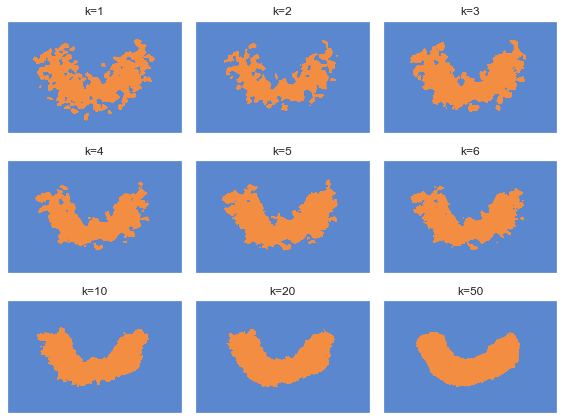

In [11]:
# Show the grid for the noisy smile dataset

show_fit_grid(X_noisy, y_noisy, 'noisy')

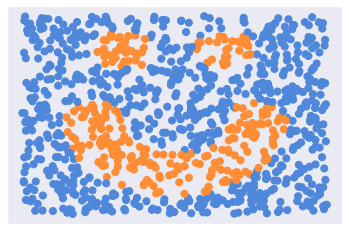

In [12]:
# Show the clean face dataset

X_clean_face, y_clean_face = make_happy_face(1000, .3, 0)
show_Xy(X_clean_face, y_clean_face, 'KNN-face-data-clean')

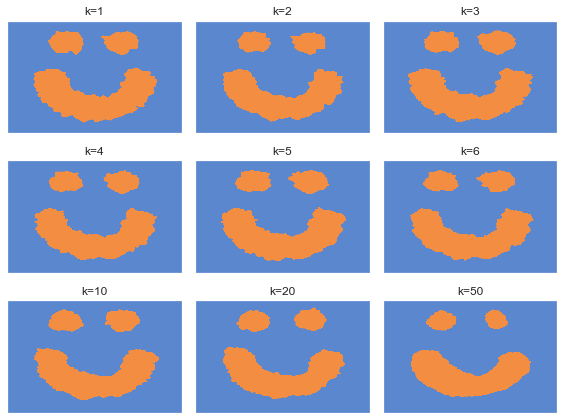

In [13]:
# Show the grid for the clean face dataset

show_fit_grid(X_clean_face, y_clean_face, 'clean-face')

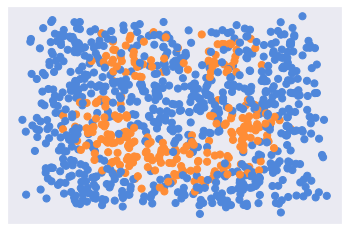

In [14]:
# Show the noisy face dataset

X_noisy_face, y_noisy_face = make_happy_face(1000, .3, .25)
show_Xy(X_noisy_face, y_noisy_face, 'KNN-face-data-noisy')

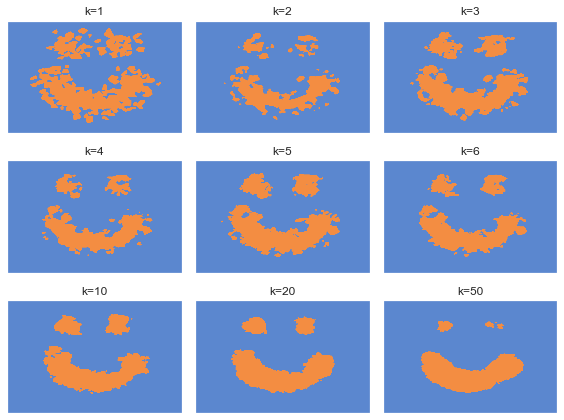

In [15]:
# Show the grid for the noisy face dataset

show_fit_grid(X_noisy_face, y_noisy_face, 'noisy-face')